<a href="https://colab.research.google.com/github/rjsdn31536/titanic_kaggle/blob/master/titanic_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Predict survival on the Titanic with ML(Kaggle competition)

## Data 로딩 및 분석

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
train_file = "/gdrive/My Drive/colab/titanic_kaggle/data/train.csv"
test_file = "/gdrive/My Drive/colab/titanic_kaggle/data/test.csv"

data_train = pd.read_csv(train_file, engine='python')
data_test = pd.read_csv(test_file, engine='python')

In [34]:
print(data_train.shape)
print(data_test.shape)

(891, 12)
(418, 11)


In [35]:
display(data_train.head())
display(data_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### feature
 - survival : 생존 유무
 - pclass : 티켓 등급
 - sec : 성별
 - age : 나이
 - sibsp : 동승한 형제자매, 배우자 수
 - parch : 동승한 부모, 자녀 수
 - ticket : 티켓 번호
 - cabin : 객실 번호
 - bembarked : 탑승 항구

## Null value 확인

In [36]:
print(data_train.shape)
data_train.isnull().sum()

(891, 12)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [37]:
print(data_test.shape)
data_test.isnull().sum()

(418, 11)


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

확인해보면 age, cabin에 대한 null value가 상당부분 존재한다. 이를 조금 후에 처리해주자

## Data 분석

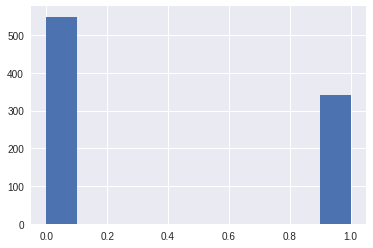

In [38]:
plt.hist(data_train["Survived"])
plt.show()

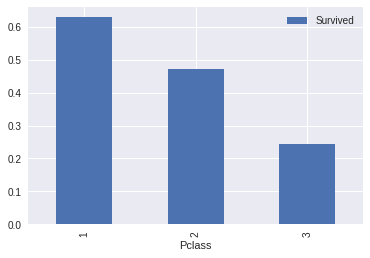

In [39]:
data_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().plot.bar()

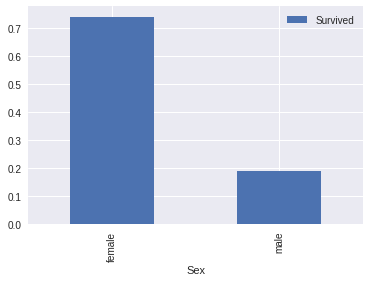

In [40]:
data_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar()

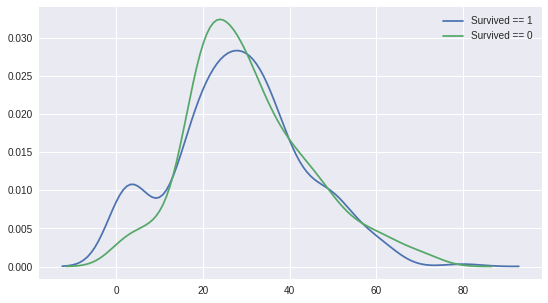

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(data_train[data_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(data_train[data_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

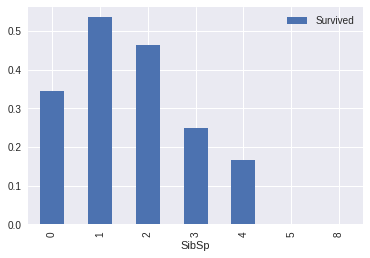

In [42]:
data_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=True).mean().plot.bar()

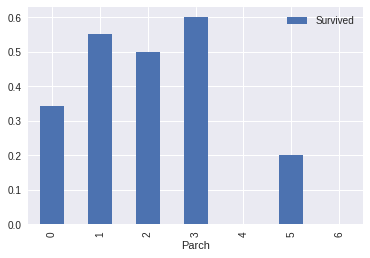

In [43]:
data_train[['Parch', 'Survived']].groupby(['Parch'], as_index=True).mean().plot.bar()

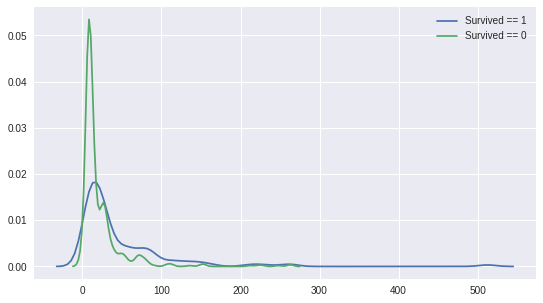

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(data_train[data_train['Survived'] == 1]['Fare'], ax=ax)
sns.kdeplot(data_train[data_train['Survived'] == 0]['Fare'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

In [0]:
for i in range(data_train['Cabin'].shape[0]):
  if type(data_train['Cabin'][i]) == str:
    if 'A' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'A'
    if 'B' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'B'
    if 'C' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'C'
    if 'D' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'D'
    if 'E' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'E'
    if 'F' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'F'
    if 'G' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'G'
  else:
    data_train['Cabin'][i]= 'None'
    
for i in range(data_test['Cabin'].shape[0]):
  if type(data_test['Cabin'][i]) == str:
    if 'A' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'A'
    if 'B' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'B'
    if 'C' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'C'
    if 'D' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'D'
    if 'E' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'E'
    if 'F' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'F'
    if 'G' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'G'
  else:
    data_test['Cabin'][i]= 'None'

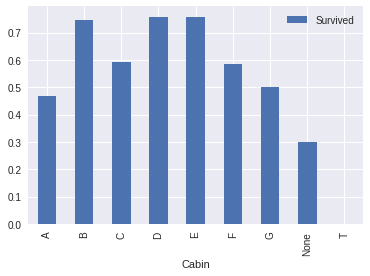

In [46]:
data_train[['Cabin', 'Survived']].groupby(['Cabin'], as_index=True).mean().plot.bar()

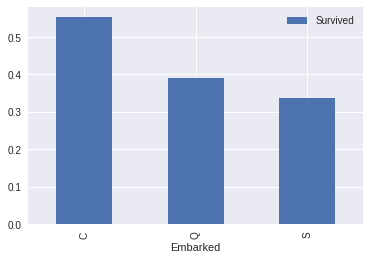

In [47]:
data_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().plot.bar()

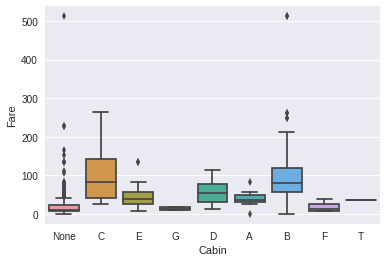

In [48]:
sns.boxplot(x='Cabin', y='Fare', data=data_train)

In [0]:
import xgboost as xgb

model = xgb.XGBClassifier()

In [0]:
y_train = data_train['Survived']
x_train = data_train.drop(['Survived'], axis=1)
x_test = data_test

In [0]:
y_train = x_train['Cabin']
y_test = x_train['Cabin']

In [54]:
x_train.drop(['Cabin'], axis = 1, inplace=True)
x_test.drop(['Cabin'], axis = 1, inplace=True)
x_train.drop(['Name'], axis = 1, inplace=True)
x_test.drop(['Name'], axis = 1, inplace=True)
x_train.drop(['PassengerId'], axis = 1, inplace=True)
x_test.drop(['PassengerId'], axis = 1, inplace=True)
x_train.drop(['Ticket'], axis = 1, inplace=True)
x_test.drop(['Ticket'], axis = 1, inplace=True)
x_train.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [55]:
  print(x_train.shape)
  x_train.isnull().sum()

(891, 7)


Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [0]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [60]:
y_train.head()

,A,B,C,D,E,F,G,None,T
0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0


In [63]:
y_test.head()

,A,B,C,D,E,F,G,None,T
0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0


In [67]:
y_test[y_test['T'] == 1]

,A,B,C,D,E,F,G,None,T
339,0,0,0,0,0,0,0,0,1


In [68]:
data_test.loc[339]

Pclass           3
Sex           male
Age            NaN
SibSp            0
Parch            0
Fare        7.2292
Embarked         C
Name: 339, dtype: object